### Add model, connection and device to settings:

In [1]:
# библиотеки
import os
import sys
import inspect
import numpy as np
import re
import math
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from hybriddomain.envs.hs.model.model_main import ModelNet as Model
from hybriddomain.settings.settings_main import Settings
from ddeint import ddeint

# пути и названия файлов
modelFileName = 'problems/hutchinson_equation2'
conn_name = "connection.json"
device_conf_name = "devices.json"

#Ввод пароля для инициализации пользователя
model = Model()
model.io.loadFromFile(modelFileName)
settings = Settings(model, conn_name, device_conf_name, conn_name)

INFO:block_main.block_io:DefaultBound not set
INFO:settings_main:device_conf_rpath
INFO:settings_main:devices.json


Please enter password for user imaslenikov:


 ·········


### Run solver:

In [2]:
# запуск процесса решения уравнения
from hybriddomain.solvers.hs.remoterun.progresses.progress_notebook import ProgressNotebook
progress = ProgressNotebook(100, prefix='solving')
from hybriddomain.solvers.hs.remoterun.remoterun import remoteProjectRun

clear_output()
test_name = settings.paths['model']['name']
bTest = widgets.Button(description="run %s " % (test_name))
def run(event):
    remoteProjectRun(settings, 1, progress)
bTest.on_click(run)
display(progress.progress)
remoteProjectRun(settings, 1, progress)
#display(bTest)

IntProgress(value=0, description='solving: ', max=99)

INFO:remoterun:
connect ...
INFO:remoterun:
connection established
INFO:remoterun:
files/folders routine
INFO:remoterun:created folder /acchome/imaslenikov/tracer/workspace/problems/hutchinson_equation2
INFO:remoterun:created folder /acchome/imaslenikov/tracer/workspace/problems/hutchinson_equation2/out
INFO:remoterun:
files/folders routine completed
INFO:remoterun:
Running preprocessor:
INFO:remoterun:command:
INFO:remoterun:~/anaconda3/bin/python3 -c "import hybriddomain.gens.hs.tests.tests_gen_1d as ts; ts.run()" -t /acchome/imaslenikov/tracer/workspace/problems/hutchinson_equation2 -d /acchome/imaslenikov/tracer/workspace/settings/device_conf/devices.json -p /acchome/imaslenikov/tracer/workspace/settings/paths/connection.json -w /acchome/imaslenikov/tracer/workspace -u imaslenikov 2>&1
INFO:remoterun:
Running solver:
INFO:remoterun:01-17 13:39:54 Performance (10^6): 0.000483334

INFO:remoterun:INFO:postproc.video:Creating images for block 0 value U

INFO:remoterun:INFO:postproc.vid

### Results:

In [3]:
# объекте model хранится вся информация по решению задачи
# get results (for TRAC-11 result_format=1):
model.readResults(result_format=1)
model.results_paths
# available results:
print(model.results_arrays.keys())

dict_keys(['U'])


### Video:

In [4]:
# available plots:
model.plots_paths

{'U': ['problems/hutchinson_equation2/out/U.mp4']}

In [5]:
display(HTML(model.get_video('U')))

### U(x, t-fixed),V(x, t-fixed):

In [10]:
"""
This module implements ddeint, a simple Differential Delay Equation
solver built on top of Scipy's odeint """

# REQUIRES Numpy and Scipy.
import numpy as np
import scipy.integrate
import scipy.interpolate


class ddeVar:
    """
    The instances of this class are special function-like
    variables which store their past values in an interpolator and
    can be called for any past time: Y(t), Y(t-d).
    Very convenient for the integration of DDEs.
    """

    def __init__(self, g, tc=0):
        """ g(t) = expression of Y(t) for t<tc """

        self.g = g
        self.tc = tc
        # We must fill the interpolator with 2 points minimum
        self.itpr = scipy.interpolate.interp1d(
            np.array([tc - 1, tc]),  # X
            np.array([self.g(tc), self.g(tc)]).T,  # Y
            kind='linear', bounds_error=False,
            fill_value=self.g(tc))

    def update(self, t, Y):
        """ Add one new (ti,yi) to the interpolator """

        self.itpr.x = np.hstack([self.itpr.x, [t]])
        Y2 = Y if (Y.size == 1) else np.array([Y]).T
        self.itpr.y = np.hstack([self.itpr.y, Y2])
        self.itpr.fill_value = Y
        self.itpr._y = self.itpr._reshape_yi(self.itpr.y)

    def __call__(self, t=0):
        """ Y(t) will return the instance's value at time t """

        return (self.g(t) if (t <= self.tc) else self.itpr(t))


class dde(scipy.integrate.ode):
    """
    This class overwrites a few functions of ``scipy.integrate.ode``
    to allow for updates of the pseudo-variable Y between each
    integration step.
    """

    def __init__(self, f, jac=None):
        def f2(t, y, args):
            return f(self.Y, t, *args)

        scipy.integrate.ode.__init__(self, f2, jac)
        self.set_f_params(None)

    def integrate(self, t, step=0, relax=0):
        scipy.integrate.ode.integrate(self, t, step, relax)
        self.Y.update(self.t, self.y)
        return self.y

    def set_initial_value(self, Y):
        self.Y = Y  # !!! Y will be modified during integration
        scipy.integrate.ode.set_initial_value(self, Y(Y.tc), Y.tc)


def ddeint(func, g, tt, fargs=None):
    """ Solves Delay Differential Equations
    Similar to scipy.integrate.odeint. Solves a Delay differential
    Equation system (DDE) defined by
        Y(t) = g(t) for t<0
        Y'(t) = func(Y,t) for t>= 0
    Where func can involve past values of Y, like Y(t-d).

    Parameters
    -----------

    func
      a function Y,t,args -> Y'(t), where args is optional.
      The variable Y is an instance of class ddeVar, which means that
      it is called like a function: Y(t), Y(t-d), etc. Y(t) returns
      either a number or a numpy array (for multivariate systems).
    g
      The 'history function'. A function g(t)=Y(t) for t<0, g(t)
      returns either a number or a numpy array (for multivariate
      systems).

    tt
      The vector of times [t0, t1, ...] at which the system must
      be solved.
    fargs
      Additional arguments to be passed to parameter ``func``, if any.
    Examples
    ---------

    We will solve the delayed Lotka-Volterra system defined as

        For t < 0:
        x(t) = 1+t
        y(t) = 2-t

        For t >= 0:
        dx/dt =  0.5* ( 1- y(t-d) )
        dy/dt = -0.5* ( 1- x(t-d) )

    The delay ``d`` is a tunable parameter of the model.
    >>> import numpy as np
    >>> from ddeint import ddeint
    >>>
    >>> def model(XY,t,d):
    >>>     x, y = XY(t)
    >>>     xd, yd = XY(t-d)
    >>>     return np.array([0.5*x*(1-yd), -0.5*y*(1-xd)])
    >>>
    >>> g = lambda t : np.array([1+t,2-t]) # 'history' at t<0
    >>> tt = np.linspace(0,30,20000) # times for integration
    >>> d = 0.5 # set parameter d
    >>> yy = ddeint(model,g,tt,fargs=(d,)) # solve the DDE !

    """

    dde_ = dde(func)
    dde_.set_initial_value(ddeVar(g, tt[0]))
    dde_.set_f_params(fargs if fargs else [])
    results = [dde_.integrate(dde_.t + dt) for dt in np.diff(tt)]
    return np.array([g(tt[0])] + results)

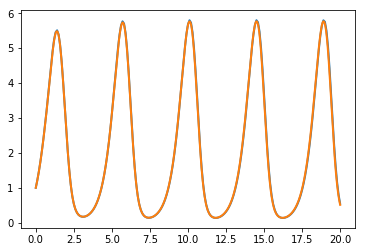

In [11]:
# отрисовывает результат
%matplotlib inline
time = model.results_arrays['U']['timevalues']

times = model.results_arrays['U']['timevalues']

result = model.results_arrays['U']['resvalues']
result_x = np.array([result[time][0][1] for time in times])
plt.plot(time, result_x, lw=2)


b = 2
h = 1
a = 2

def model1(Y,t,d):
    y=Y(t)
    yd=Y(t-h)
    return np.array([a * (1 - ( yd/b)) * y])
g=lambda t : t+1

#model1 = lambda Y,t, k,h,r :  a * (1 - ( Y(t-h)/b)) * Y(t)
#g = lambda t: t+1 # history before t=0
tt = np.linspace(0,20,20001)
for d in [0,0.2]:
    answer_DDE = ddeint(model1, g, tt, fargs=(d,)) # K=0.1, d=5, r=1
plt.plot(tt, answer_DDE, lw=2)
plt.show()


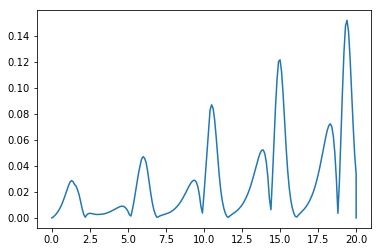

In [12]:
# отрисовывает отклонение нашего решения от решения DDE
%matplotlib inline

time = model.results_arrays['U']['timevalues']
times = model.results_arrays['U']['timevalues']
result = model.results_arrays['U']['resvalues']

result_x = np.array([result[time][0][1] for time in times])
b = 2
h = 1
a = 2

def model1(Y,t,d):
    y=Y(t)
    yd=Y(t-h)
    return np.array([a * (1 - ( yd/b)) * y])
g=lambda t : t+1

#количество точек для использования построения решения
tt =np.linspace (0.0,20.0,20001)
for d in [0,0.2]:
    answer_DDE = ddeint (model1,g,tt,fargs=(d,))
#print(time)
i = 0
#print(len(answer_DDE))
#print(len(result_x))
find_error = []
#print(time)
for i in range(len(time)):
    if(i<=len(time)-2):
        b = abs(answer_DDE[i*100]-result_x[i])
        find_error.append(b)
#print(len(find_error))
find_error.append(0)
plt.plot(time, find_error)


plt.show()


#Показать в явном виде разницу между результатами
#i = 0
#for poi in time:
#    print(answer_DDE[i*10,0],result_x[i])
#    i+=1